### Clean, Format and Convert all facts texts into BERT embeddings

Alter BERT models at this **feature engineering** phase.

In [18]:
!pip install transformers scikit-learn seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [1]:
# ============================================================================
# CONFIGURATION PARAMETERS
# ============================================================================

# Data Configuration
DATA_PATH = "C:\\Users\\rhrou\\Downloads\\justice.csv"
TARGET_COLUMN = 'first_party_winner'
TEXT_COLUMN = 'facts'

# Train-Test Split Configuration
TEST_SIZE = 0.25
RANDOM_STATE = 42

# BERT Configuration
# Options: 'bert-base-uncased', 'nlpaueb/legal-bert-base-uncased'
BERT_MODEL_NAME = 'bert-base-uncased'  

BERT_MAX_LENGTH = 512
BERT_BATCH_SIZE = 40

# Text Preprocessing Configuration
LOWERCASE = True  # Set to True for 'uncased' models, False for 'cased' models
NORMALIZE_UNICODE = True

In [2]:
"""
BERT Feature Preparation for Legal Outcome Prediction
Streamlined script for data loading, preprocessing, and BERT feature extraction
"""

import numpy as np
import pandas as pd
import unicodedata
import warnings
warnings.filterwarnings('ignore')

import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ============================================================================
# PREPROCESSING FUNCTION
# ============================================================================

def preprocess_text(text, lowercase=True, normalize=True):
    """
    Minimal cleaning for BERT:
    - Trim whitespace
    - Optional Unicode normalization (NFKC)
    - Optional lowercasing (use True for uncased models; False for cased models)
    """
    if text is None:
        return ""
    text = str(text).strip()
    if normalize:
        text = unicodedata.normalize("NFKC", text)
    if lowercase:
        text = text.lower()
    return text

# ============================================================================
# BERT FEATURE EXTRACTOR CLASS
# ============================================================================

class BERTFeatureExtractor:
    def __init__(self, model_name='bert-base-uncased', max_length=512, precision='fp16'):
        self.model_name = model_name
        self.max_length = max_length
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.precision = precision.lower()

        if self.precision == 'fp16':
            self.torch_dtype = torch.float16
        elif self.precision == 'bf16':
            self.torch_dtype = torch.bfloat16
        else:
            self.torch_dtype = torch.float32

        self.tokenizer = BertTokenizer.from_pretrained(model_name, use_fast=True)
        self.model = BertModel.from_pretrained(model_name, torch_dtype=self.torch_dtype, low_cpu_mem_usage=True)
        self.model.to(self.device).eval()

        # Optional: BetterTransformer is fine on Windows
        try: self.model = self.model.to_bettertransformer()
        except Exception: pass

        # Only try compile on non-Windows (avoid 'cl not found')
        try:
            if platform.system() != "Windows":
                self.model = torch.compile(self.model)
        except Exception as e:
            print(f"[info] torch.compile disabled: {e}")

        torch.backends.cuda.matmul.allow_tf32 = True
        torch.set_float32_matmul_precision("high")

    def extract_features(self, texts, batch_size=32, pool='cls'):
        use_autocast = (self.device.type == 'cuda' and self.torch_dtype in (torch.float16, torch.bfloat16))
        all_embeddings = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = self.tokenizer(batch, padding='max_length', truncation=True,
                                 max_length=self.max_length, return_tensors='pt')
            ids = enc['input_ids'].to(self.device, non_blocking=True)
            mask = enc['attention_mask'].to(self.device, non_blocking=True)

            with torch.inference_mode():
                if use_autocast:
                    with torch.autocast(device_type='cuda', dtype=self.torch_dtype):
                        out = self.model(input_ids=ids, attention_mask=mask)
                else:
                    out = self.model(input_ids=ids, attention_mask=mask)

                last = out.last_hidden_state
                if pool == 'cls':
                    feats = last[:, 0, :]
                else:
                    m = mask.unsqueeze(-1)
                    feats = (last * m).sum(1) / m.sum(1).clamp_min(1)

            all_embeddings.append(feats.detach().cpu().numpy())
        return np.vstack(all_embeddings)


# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    print("="*70)
    print("BERT FEATURE PREPARATION PIPELINE")
    print("="*70)
    
    # 1. Load Data
    print(f"\n[1/6] Loading data from: {DATA_PATH}")
    df = pd.read_csv(DATA_PATH)
    print(f"      Loaded: {df.shape[0]} cases, {df.shape[1]} columns")
    
    # 2. Remove Missing Values
    print(f"\n[2/6] Removing missing values...")
    initial_count = df.shape[0]
    df.dropna(inplace=True)
    print(f"      Retained: {df.shape[0]} cases ({df.shape[0]/initial_count*100:.1f}%)")
    
    # 4. Extract and Clean Text
    print(f"\n[3/6] Preprocessing text data...")
    df_nlp = df[[TEXT_COLUMN]].copy()
    
    # Remove HTML tags
    df_nlp[TEXT_COLUMN] = df_nlp[TEXT_COLUMN].str.replace(r'<[^<>]*>', '', regex=True)
    
    # Apply text preprocessing
    df_nlp['facts_clean'] = df_nlp[TEXT_COLUMN].apply(
        lambda x: preprocess_text(x, lowercase=LOWERCASE, normalize=NORMALIZE_UNICODE)
    )
    
    # 6. Combine with Target Variable
    df_target = df[[TARGET_COLUMN]].copy()
    df_target[TARGET_COLUMN] = df_target[TARGET_COLUMN].astype(int)
    df_final = pd.concat([df_nlp[['facts_clean']], df_target], axis=1, join='inner')
    
    print(f"      Final dataset shape: {df_final.shape}")
    print(f"      Target distribution: {df_final[TARGET_COLUMN].value_counts(normalize=True).to_dict()}")
    
    # 7. Prepare Features and Target
    X = df_final['facts_clean']
    y = df_final[TARGET_COLUMN]
    
    # 10. Train-Test Split
    print(f"\n[4/6] Splitting data (test_size={TEST_SIZE})...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y
    )
    print(f"      Training set: {len(X_train)} cases")
    print(f"      Test set: {len(X_test)} cases")
    
    # 11. Extract BERT Features
    print(f"\n[5/6] Initializing BERT model: {BERT_MODEL_NAME}")
    bert_extractor = BERTFeatureExtractor(
        model_name=BERT_MODEL_NAME,
        max_length=BERT_MAX_LENGTH
    )
    print(f"      Device: {bert_extractor.device}")
    
    print(f"\n[6/6] Extracting BERT features...")
    print("      Processing training set...")
    X_train_bert = bert_extractor.extract_features(
        X_train.tolist(),
        batch_size=BERT_BATCH_SIZE
    )
    
    print("      Processing test set...")
    X_test_bert = bert_extractor.extract_features(
        X_test.tolist(),
        batch_size=BERT_BATCH_SIZE
    )
    
    # Final Summary
    print("\n" + "="*70)
    print("FEATURE EXTRACTION COMPLETE")
    print("="*70)
    print(f"\nConfiguration:")
    print(f"  - BERT Model: {BERT_MODEL_NAME}")
    print(f"  - Max Length: {BERT_MAX_LENGTH}")
    print(f"  - Batch Size: {BERT_BATCH_SIZE}")
    print(f"  - Test Split: {TEST_SIZE*100:.0f}%")
    
    print(f"\nOutput Shapes:")
    print(f"  - X_train_bert: {X_train_bert.shape} (samples × features)")
    print(f"  - X_test_bert:  {X_test_bert.shape}")
    print(f"  - y_train:      {y_train.shape}")
    print(f"  - y_test:       {y_test.shape}")
    
    print(f"\nTarget Distribution:")
    print(f"  - Training:   {y_train.value_counts(normalize=True).to_dict()}")
    print(f"  - Test:       {y_test.value_counts(normalize=True).to_dict()}")
    
    print(f"\nFeature vector dimension: {X_train_bert.shape[1]}")
    print("="*70)
    
    return X_train_bert, X_test_bert, y_train, y_test

# ============================================================================
# ENTRY POINT
# ============================================================================

if __name__ == "__main__":
    X_train_bert, X_test_bert, y_train, y_test = main()
    
    # Save features for next stage (optional)
    # np.save('X_train_bert.npy', X_train_bert)
    # np.save('X_test_bert.npy', X_test_bert)
    # np.save('y_train.npy', y_train)
    # np.save('y_test.npy', y_test)

BERT FEATURE PREPARATION PIPELINE

[1/6] Loading data from: C:\Users\rhrou\Downloads\justice.csv
      Loaded: 3303 cases, 16 columns

[2/6] Removing missing values...
      Retained: 3098 cases (93.8%)

[3/6] Preprocessing text data...
      Final dataset shape: (3098, 2)
      Target distribution: {1: 0.6672046481601033, 0: 0.3327953518398967}

[4/6] Splitting data (test_size=0.25)...
      Training set: 2323 cases
      Test set: 775 cases

[5/6] Initializing BERT model: bert-base-uncased


`torch_dtype` is deprecated! Use `dtype` instead!


[info] torch.compile disabled: name 'platform' is not defined
      Device: cuda

[6/6] Extracting BERT features...
      Processing training set...
      Processing test set...

FEATURE EXTRACTION COMPLETE

Configuration:
  - BERT Model: bert-base-uncased
  - Max Length: 512
  - Batch Size: 40
  - Test Split: 25%

Output Shapes:
  - X_train_bert: (2323, 768) (samples × features)
  - X_test_bert:  (775, 768)
  - y_train:      (2323,)
  - y_test:       (775,)

Target Distribution:
  - Training:   {1: 0.667240637107189, 0: 0.332759362892811}
  - Test:       {1: 0.6670967741935484, 0: 0.3329032258064516}

Feature vector dimension: 768


In [3]:
data = pd.read_csv(DATA_PATH)

data.value_counts(data['first_party_winner'])

first_party_winner
True     2140
False    1148
Name: count, dtype: int64

In [23]:
"""
Legal Outcome Classification with BERT Features
Streamlined script for training and evaluating classification models on BERT embeddings
"""

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# CONFIGURATION PARAMETERS
# ============================================================================

# Input Data Configuration
# Option 1: Load from saved arrays
X_TRAIN_PATH = 'X_train_bert.npy'
X_TEST_PATH = 'X_test_bert.npy'
Y_TRAIN_PATH = 'y_train.npy'
Y_TEST_PATH = 'y_test.npy'

# Option 2: Assume variables are already in memory from previous script
# Set LOAD_FROM_FILES = False and ensure X_train_bert, X_test_bert, y_train, y_test exist
LOAD_FROM_FILES = False

# Classifier Configuration
CLASSIFIERS_TO_TRAIN = ['logistic', 'random_forest', 'knn']  # Options: 'logistic', 'random_forest', 'knn'

# Logistic Regression Parameters
LR_C = 1.0  # Regularization strength (lower = stronger regularization)
LR_MAX_ITER = 1000
LR_SOLVER = 'liblinear'  # Options: 'liblinear', 'lbfgs', 'saga'

# Random Forest Parameters
RF_N_ESTIMATORS = 100  # Number of trees
RF_MAX_DEPTH = None  # Maximum tree depth (None = no limit)
RF_MIN_SAMPLES_SPLIT = 2
RF_MIN_SAMPLES_LEAF = 1

# K-Nearest Neighbors Parameters
KNN_N_NEIGHBORS = 5  # Number of neighbors
KNN_WEIGHTS = 'uniform'  # Options: 'uniform', 'distance'
KNN_METRIC = 'minkowski'  # Options: 'euclidean', 'manhattan', 'minkowski'

# Baseline Comparison Configuration
RUN_BASELINE = True  # Compare with bag-of-words baseline
BASELINE_MAX_FEATURES = 5000

# Output Configuration
SAVE_RESULTS = False
RESULTS_PATH = 'classification_results.csv'
PLOT_RESULTS = True
SAVE_PLOTS = False
PLOT_PATH = 'model_comparison.png'

# Random State for Reproducibility
RANDOM_STATE = 42


CLASSIFICATION MODELING PIPELINE

[1/4] Using BERT features from memory...
      X_train_bert: (2323, 768)
      X_test_bert:  (775, 768)
      y_train:      (2323,)
      y_test:       (775,)

[2/4] Initializing classifiers...
      Classifiers to train: ['Logistic Regression', 'Random Forest', 'K-Nearest Neighbors']

[3/4] Training and evaluating models...

Training: Logistic Regression

Accuracy: 0.6103 (61.03%)

Classification Report:
                      precision    recall  f1-score   support

First Party Lost (0)     0.3659    0.2326    0.2844       258
 First Party Won (1)     0.6759    0.7988    0.7323       517

            accuracy                         0.6103       775
           macro avg     0.5209    0.5157    0.5083       775
        weighted avg     0.5727    0.6103    0.5832       775


Confusion Matrix:
[[ 60 198]
 [104 413]]

Training: Random Forest

Accuracy: 0.6439 (64.39%)

Classification Report:
                      precision    recall  f1-score   support

F

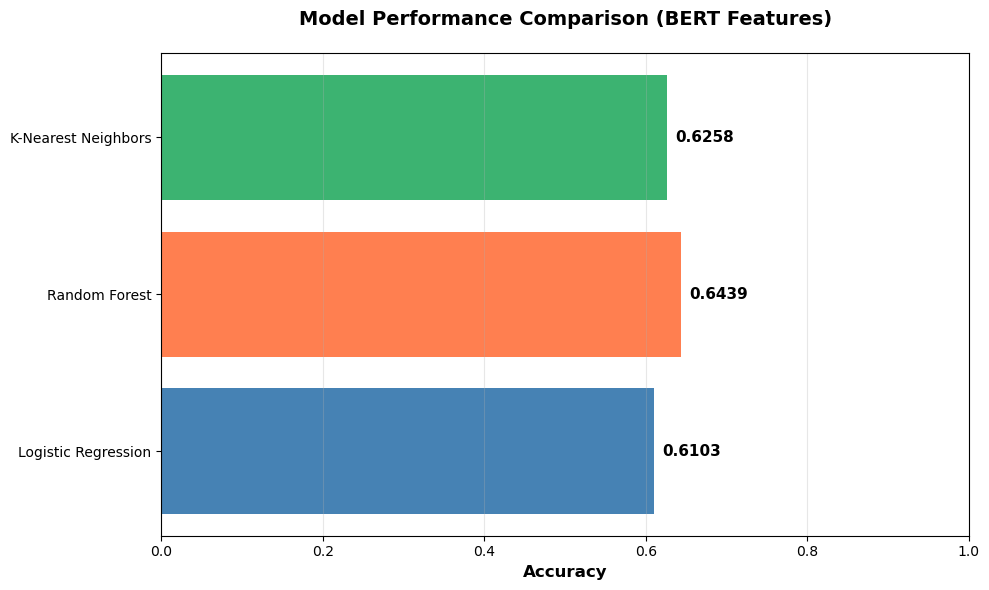


CLASSIFICATION COMPLETE


In [24]:

# ============================================================================
# CLASSIFIER DEFINITIONS
# ============================================================================

def get_classifiers():
    """Initialize classifiers with configured parameters"""
    classifiers = {}
    
    if 'logistic' in CLASSIFIERS_TO_TRAIN:
        classifiers['Logistic Regression'] = LogisticRegression(
            C=LR_C,
            solver=LR_SOLVER,
            max_iter=LR_MAX_ITER,
            random_state=RANDOM_STATE
        )
    
    if 'random_forest' in CLASSIFIERS_TO_TRAIN:
        classifiers['Random Forest'] = RandomForestClassifier(
            n_estimators=RF_N_ESTIMATORS,
            max_depth=RF_MAX_DEPTH,
            min_samples_split=RF_MIN_SAMPLES_SPLIT,
            min_samples_leaf=RF_MIN_SAMPLES_LEAF,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
    
    if 'knn' in CLASSIFIERS_TO_TRAIN:
        classifiers['K-Nearest Neighbors'] = KNeighborsClassifier(
            n_neighbors=KNN_N_NEIGHBORS,
            weights=KNN_WEIGHTS,
            metric=KNN_METRIC,
            n_jobs=-1
        )
    
    return classifiers

# ============================================================================
# EVALUATION FUNCTIONS
# ============================================================================

def evaluate_classifier(name, clf, X_train, X_test, y_train, y_test):
    """Train and evaluate a single classifier"""
    print(f"\n{'='*70}")
    print(f"Training: {name}")
    print(f"{'='*70}")
    
    # Train
    clf.fit(X_train, y_train)
    
    # Predict
    y_pred = clf.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print results
    print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"\nClassification Report:")
    print(classification_report(
        y_test, y_pred,
        target_names=['First Party Lost (0)', 'First Party Won (1)'],
        digits=4
    ))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    return accuracy, y_pred, cm

def plot_results(results, save_path=None):
    """Visualize model performance comparison"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    models = list(results.keys())
    accuracies = [results[m] for m in models]
    
    colors = ['steelblue', 'coral', 'mediumseagreen', 'orchid', 'gold']
    bars = ax.barh(models, accuracies, color=colors[:len(models)])
    
    ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance Comparison (BERT Features)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xlim([0, 1.0])
    
    # Add value labels
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        ax.text(acc + 0.01, i, f'{acc:.4f}', 
                va='center', fontsize=11, fontweight='bold')
    
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nPlot saved to: {save_path}")
    
    plt.show()

def run_baseline_comparison(X_train_text, X_test_text, y_train, y_test):
    """Run bag-of-words baseline for comparison"""
    print(f"\n{'='*70}")
    print("BASELINE: CountVectorizer (Bag-of-Words)")
    print(f"{'='*70}")
    
    vectorizer = CountVectorizer(max_features=BASELINE_MAX_FEATURES)
    X_train_bow = vectorizer.fit_transform(X_train_text)
    X_test_bow = vectorizer.transform(X_test_text)
    
    print(f"\nBag-of-Words feature shape: {X_train_bow.shape}")
    
    baseline_clf = LogisticRegression(
        solver=LR_SOLVER,
        max_iter=LR_MAX_ITER,
        random_state=RANDOM_STATE
    )
    baseline_clf.fit(X_train_bow, y_train)
    y_pred_baseline = baseline_clf.predict(X_test_bow)
    baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
    
    print(f"\nBaseline Accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
    
    return baseline_accuracy

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main(X_train_bert=None, X_test_bert=None, y_train=None, y_test=None, 
         X_train_text=None, X_test_text=None):
    """
    Main classification pipeline
    
    Parameters:
    -----------
    X_train_bert : array, shape (n_train_samples, n_features)
        Training BERT features
    X_test_bert : array, shape (n_test_samples, n_features)
        Test BERT features
    y_train : array, shape (n_train_samples,)
        Training labels
    y_test : array, shape (n_test_samples,)
        Test labels
    X_train_text : array-like (optional)
        Original training text for baseline comparison
    X_test_text : array-like (optional)
        Original test text for baseline comparison
    """
    
    print("="*70)
    print("CLASSIFICATION MODELING PIPELINE")
    print("="*70)
    
    # Load data if needed
    if LOAD_FROM_FILES:
        print(f"\n[1/4] Loading BERT features from files...")
        X_train_bert = np.load(X_TRAIN_PATH)
        X_test_bert = np.load(X_TEST_PATH)
        y_train = np.load(Y_TRAIN_PATH)
        y_test = np.load(Y_TEST_PATH)
        print(f"      Loaded successfully")
    else:
        print(f"\n[1/4] Using BERT features from memory...")
    
    print(f"      X_train_bert: {X_train_bert.shape}")
    print(f"      X_test_bert:  {X_test_bert.shape}")
    print(f"      y_train:      {y_train.shape}")
    print(f"      y_test:       {y_test.shape}")
    
    # Initialize classifiers
    print(f"\n[2/4] Initializing classifiers...")
    classifiers = get_classifiers()
    print(f"      Classifiers to train: {list(classifiers.keys())}")
    
    # Train and evaluate
    print(f"\n[3/4] Training and evaluating models...")
    results = {}
    predictions = {}
    confusion_matrices = {}
    
    for name, clf in classifiers.items():
        accuracy, y_pred, cm = evaluate_classifier(
            name, clf, X_train_bert, X_test_bert, y_train, y_test
        )
        results[name] = accuracy
        predictions[name] = y_pred
        confusion_matrices[name] = cm
    
    # Baseline comparison
    baseline_accuracy = None
    if RUN_BASELINE and X_train_text is not None and X_test_text is not None:
        baseline_accuracy = run_baseline_comparison(
            X_train_text, X_test_text, y_train, y_test
        )
        results['Baseline (BoW)'] = baseline_accuracy
    
    # Summary
    print(f"\n[4/4] Generating summary...")
    print("\n" + "="*70)
    print("FINAL RESULTS SUMMARY")
    print("="*70)
    
    print(f"\nModel Performance (Test Set Accuracy):")
    print("-" * 70)
    
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
    
    for rank, (name, acc) in enumerate(sorted_results, 1):
        print(f"{rank}. {name:30s}: {acc:.4f} ({acc*100:.2f}%)")
    
    print("-" * 70)
    print(f"\nBest Model: {sorted_results[0][0]}")
    print(f"Best Accuracy: {sorted_results[0][1]:.4f}")
    
    if baseline_accuracy is not None and 'Logistic Regression' in results:
        improvement = results['Logistic Regression'] - baseline_accuracy
        print(f"\nBERT vs Baseline Improvement: {improvement:.4f} ({improvement*100:.2f}%)")
    
    # Save results
    if SAVE_RESULTS:
        results_df = pd.DataFrame([
            {'Model': name, 'Accuracy': acc, 'Accuracy_Percent': acc*100}
            for name, acc in sorted_results
        ])
        results_df.to_csv(RESULTS_PATH, index=False)
        print(f"\nResults saved to: {RESULTS_PATH}")
    
    # Plot results
    if PLOT_RESULTS:
        plot_path = PLOT_PATH if SAVE_PLOTS else None
        plot_results(results, save_path=plot_path)
    
    print("\n" + "="*70)
    print("CLASSIFICATION COMPLETE")
    print("="*70)
    
    return results, predictions, confusion_matrices

# ============================================================================
# ENTRY POINT
# ============================================================================

if __name__ == "__main__":
    # If running standalone, load from files
    if LOAD_FROM_FILES:
        results, predictions, confusion_matrices = main()
    else:
        # If running after feature extraction script, pass variables
        # Assumes X_train_bert, X_test_bert, y_train, y_test are in scope
        try:
            results, predictions, confusion_matrices = main(
                X_train_bert, X_test_bert, y_train, y_test
            )
        except NameError:
            print("\nError: BERT features not found in memory.")
            print("Either set LOAD_FROM_FILES=True or run after feature extraction script.")
            print("Example:")
            print("  # Run feature extraction first")
            print("  exec(open('bert_feature_preparation.py').read())")
            print("  # Then run classification")
            print("  exec(open('bert_classification.py').read())")